In [1]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

import albumentations as A

import random
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2

### Data Loading and Preprocessing

In [2]:
# Setting up our path variables
DATA_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data'
TRAIN_CSV = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/train.csv'
TRAIN_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/train'
TEST_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/test'
MASK_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/masks'
MASK_COMPILED_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/masks_compiled'

In [3]:
# Load training data into pandas dataframe
train = pd.read_csv(TRAIN_CSV)

In [4]:
# Verify the data has been loaded correctly
train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [5]:
def show_images(num=9):
    """Display a number of images to check data"""
    plt.figure(figsize=(20,20))
    for i in range(num):
        plt.subplot(3, 3, i+1)
        img = cv2.imread(f'{TRAIN_PATH}/{train.iloc[i, 0]}.png')
        plt.imshow(img)

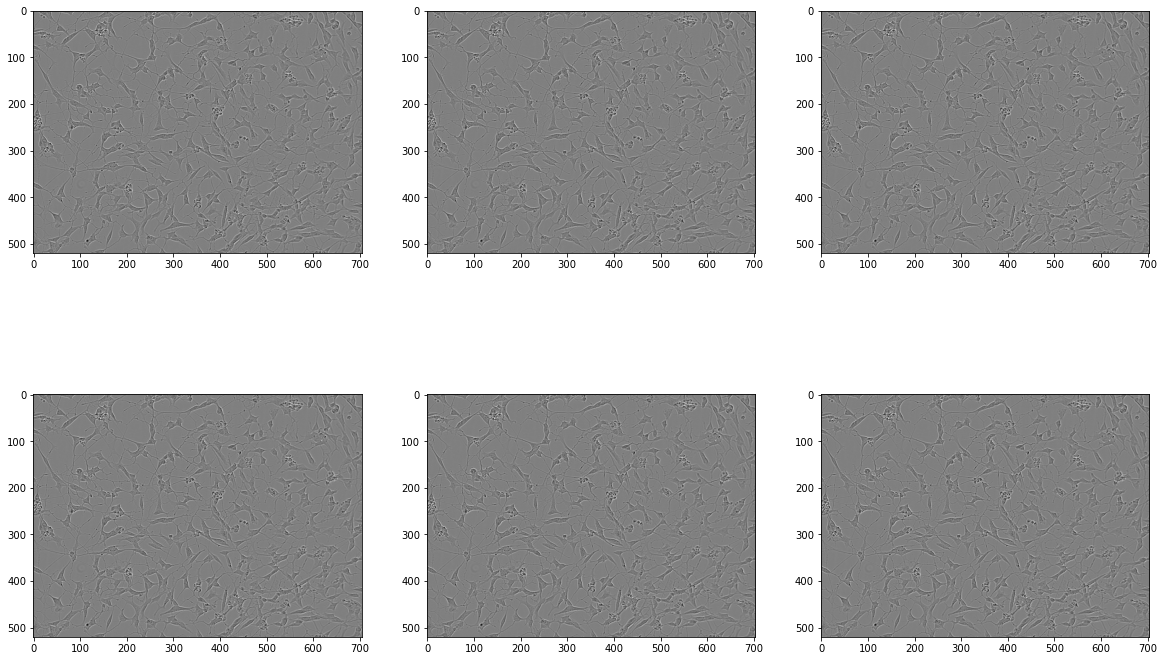

In [6]:
show_images(6)

In [7]:
print(f'Training Set Shape: {train.shape} - {train["id"].nunique()} \
Images - Memory Usage: {train.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape: (73585, 9) - 606 Images - Memory Usage: 5.05 MB


### Run Length Encoding and Decoding
* Annotations in train.csv are rle encoded
* Each instance must be decoded into a mask and saved
* Each mask corresponding to a certain image will be compiled into one mask and saved

In [8]:
def decode(rle, shape):
    """
    Takes an Run Length Encoded input and converts it into a numpy array
    rle: reun length encoded string
    shape: tuple of dimensions for the final array
    Returns: a numpy array where 1 corresponds to the annotation and 0 is nothing
    """
    rle_list = rle.split() # List of alternating pixel and RL values
    pixels = rle_list[::2]
    run_lengths = rle_list[1::2]
    # Convert to numpy arrays
    pixels_arr = np.asarray(pixels, dtype=int)
    lengths_np = np.asarray(run_lengths, dtype=int)
    # Calculate start and stop pixels for each rle pair
    pixel_start =  np.subtract(pixels_arr, int(1))
    pixel_stop = pixel_start + lengths_np
    # Create an empty numpy array to fill with mask
    mask = np.zeros(shape[0] * shape[1])
    for start, stop in zip(pixel_start, pixel_stop):
        mask[start:stop] = 255
    return mask.reshape(shape) # Numpy array


def encode(mask):
    """
    mask: the mask to perform run length encoding on
    Returns: a tuple (img_id, annotation)
    """
    raise NotImplementedError("Implement Encoding Function")

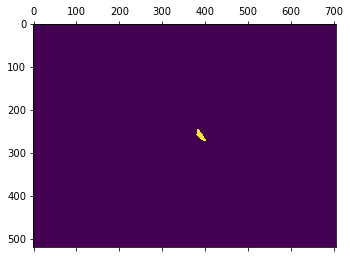

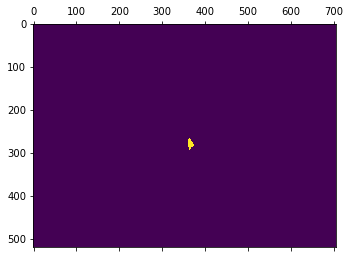

In [9]:
# Testing the rle decoder
X = decode("173567 3 174270 5 174974 5 175678 6 176382 7 177085 9 177789 9 178493 \
            10 179197 11 179901 12 180605 12 181308 14 182012 15 182716 15 183420 \
            16 184125 16 184831 15 185536 14 186241 14 186947 12 187651 13 188356 \
            12 189061 12 189767 10 190472 10 191177 9 191883 7 192589 5 193295 2 194000 1", (520, 704))
plt.matshow(X)
plt.show()
X = decode(train["annotation"][1], (520, 704))
plt.matshow(X)
plt.show()

### Applying decoding to training dataframe

In [10]:
train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [11]:
# Loads each image into a data frame but I opted to just write them to my ssd with cv2.imwrite instead
def build_masks(df, shape=(520, 704)):
    """
    Takes the training dataframe and returns a dataframe of image masks
    df: training dataframe
    shape: the shape of the images; default=(704, 520)
    Returns a dataframe of the image masks
    """
    id_nums = df["id"].tolist()
    print(type(id_nums))
    annotations = df["annotation"].tolist()
    print(type(annotations))
    label_dict = {}
    for i, annotation in zip(id_nums, annotations):
        print(i)
        label_dict[i] = decode(annotation, shape=(520, 704))
    return pd.DataFrame(label_dict)


# Decode and store all annotations
def save_masks(df, shape=(520, 704)):
    """
    Takes the training dataframe, performs rle decoding on each instance,
    and writes each mask to the data directory with cv2.
    df: training dataframe
    shape: the shape of the images; default=(704, 520)
    """
    id_nums = df["id"].tolist()
    annotations = df["annotation"].tolist()
    path = DATA_PATH
    images = os.listdir(f'{path}/train')
    label_dict = {}
    inst_list = []
    count = 0
    for image in images:
        os.mkdir(f'{path}/masks/{image[0:12]}')
    for i, (img_id, annotation) in enumerate(zip(id_nums, annotations)):
        if (img_id not in inst_list):
            count = 0
            inst_list.append(img_id)
        img = decode(annotation, shape)
        if (i % 1000 == 0):
            print(f'Image: {img_id}\nInstance: {count}')
            plt.matshow(img)
            plt.show()
        cv2.imwrite(f'{path}/masks/{img_id}/{count}.png', img)
        count += 1


# Compile annotations into one mask for each image
def compile_masks(df, shape=(520, 704, 3)):
    """
    Takes the training data frame, and compiles all the saved
    masks corresponding to one training sample into one image.
    Saves the compiled masks and repeats for every image.
    df: training dataframe
    shape: shape of the images to save.
    """
    path = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data'
    images = os.listdir(f'{path}/train') 
    for i, image in enumerate(images):
        masks = np.zeros(shape)
        instances = os.listdir(f'{path}/masks/{image[0:12]}')
        for instance in instances:
            masks += cv2.imread(f'{path}/masks/{image[0:12]}/{instance}')
        masks = np.clip(masks, 0.0, 255.0)
        cv2.imwrite(f'{path}/masks_compiled/{image}', masks)
        if (i % 10 == 0):
            print(f'Image: {image[0:12]} ({i}/{len(images)})')
            plt.matshow(masks)
            plt.show()

In [12]:
# Uncomment to generate mask images
#save_masks(train)

In [13]:
# Uncomment to generate compiled mask images
#compile_masks(train)


<class 'numpy.ndarray'>
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]


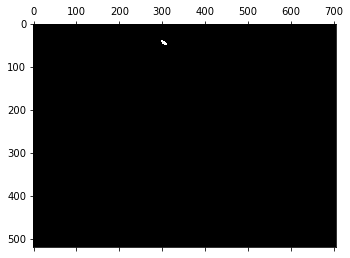

In [14]:
# Checking save_masks()
test_img = cv2.imread('C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/masks/0f08d640930b/10.png')
print(type(test_img))
print(test_img[0])
plt.matshow(test_img)
plt.show()

Mask Count: 606
['0030fd0e6378.png', '0140b3c8f445.png', '01ae5a43a2ab.png', '026b3c2c4b32.png', '029e5b3b89c7.png', '0323e81d23d9.png', '03b27b381a5f.png', '042c17cd9143.png', '042dc0e561a4.png', '04928f0866b0.png', '049f02e0f764.png', '04cd81dfb245.png', '053d61766edb.png', '05c61f0f46b7.png', '061b49d7dbbb.png', '06c5740c8b18.png', '0728b8f39241.png', '07e9ba109e34.png', '083b178bb184.png', '085eb8fec206.png', '08f52aa2add3.png', '097d60b2cf71.png', '0a6ecc5fe78a.png', '0ba181d412da.png', '0c5938ac5e3c.png']


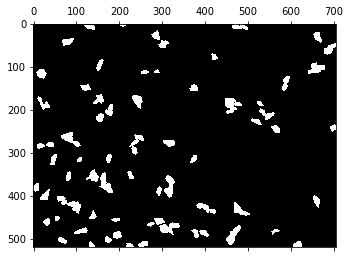

In [15]:
# Checking masks_compile()
mask_files = os.listdir('C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/masks_compiled')
test_img = cv2.imread('C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/masks_compiled/0f08d640930b.png')
print(f'Mask Count: {len(mask_files)}')
print(mask_files[0:25])
plt.matshow(test_img)
plt.show()

In [16]:
# Set up GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [17]:
# Building torch.util.data.Dataset class
class CellDataset(Dataset):
    def __init__(self, data=train, train=False, transform=None):
        # Load data
        self.data = data
        # Prepare the path variables
        self.BASE_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data'
        self.mask_paths = os.listdir(f'{self.BASE_PATH}/masks_compiled')
        self.img_paths = os.listdir(f'{self.BASE_PATH}/train')
        # Register any transforms
        self.transforms = transform
            
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        # Read the specific image and its respective compiled mask
        mask = cv2.imread(f'{self.BASE_PATH}/masks_compiled/{self.mask_paths[index]}')
        img = cv2.imread(f'{self.BASE_PATH}/train/{str(self.mask_paths[index])[0:12]}.png')
        # Apply any transforms to both and return them
        if self.transforms:
            transformed = self.transforms(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        return self.mask_paths[index][0:12], img, mask


# I probably won't need this method because the PyTorch DataLoader default_collate method converts to torch tensors from np
class ToTensor:
    def __call__(self, sample):
        img, mask = sample
        return torch.from_numpy(img.astype(np.float32)), torch.from_numpy(mask.astype(np.float32)).to(device)
        

Mask Shape: (520, 704, 3)
Img Shape: (520, 704, 3)
Image ID: 01ae5a43a2ab


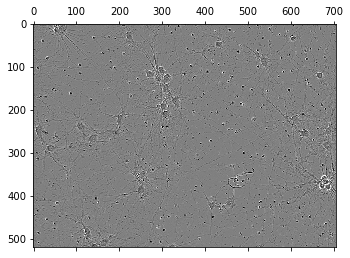

Mask ID: 01ae5a43a2ab


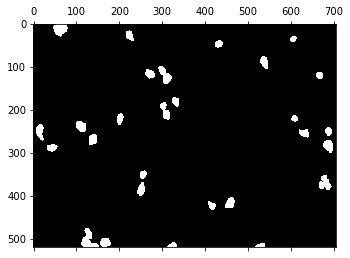

Combined:


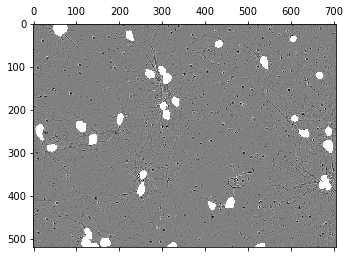

In [18]:
# Testing basic dataset functionality
cell_data = CellDataset(data=train, train=False)
img_id, img, mask = cell_data[2]
img = img.astype(int)
mask = mask.astype(int)
print(f'Mask Shape: {mask.shape}\nImg Shape: {img.shape}')
print(f'Image ID: {img_id}')
plt.matshow(img)
plt.show()
print(f'Mask ID: {img_id}')
plt.matshow(mask)
plt.show()
print('Combined:')
plt.matshow(np.clip((img + mask), 0, 255)) # dtype is int; clip at 255
plt.show()

### Data Augmentations

Image Type: float32
Mask Type: float32

Image Shape: (512, 512, 3)
Mask Shape: (512, 512, 3)


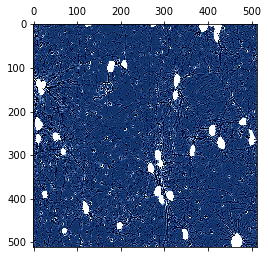

In [19]:
# Building a full list of transforms with Albumentations
transforms = A.Compose([A.Resize(512, 512),
                       A.Normalize(mean=(0.485, 0.456, 0.406),
                                    std=(0.229, 0.224, 0.225),
                                    max_pixel_value=255.0,
                                    p=1.0),
                       A.HorizontalFlip(p=0.5),
                       A.VerticalFlip(p=0.5)])
# Transformed dataset
cell_data = CellDataset(data=train, train=False, transform=transforms)
# Picking an arbitrary sample
img_id, img, mask = cell_data[2]
print(f'Image Type: {img.dtype}\nMask Type: {img.dtype}\n')
print(f'Image Shape: {img.shape}\nMask Shape: {mask.shape}')
masked = np.clip((mask + img), 0, 1) # The data has been normalized so now we are working with floats and clipping at 1.0
plt.matshow(masked)
plt.show()

### DataLoader Class

In [20]:
# Create the data loader
cell_dl = DataLoader(cell_data, batch_size=4, drop_last=True)

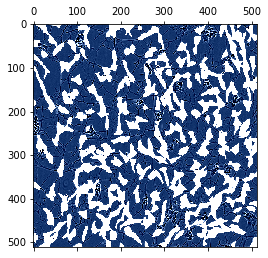

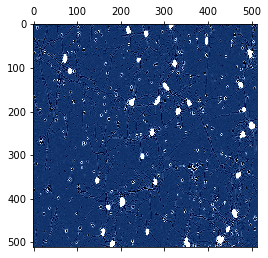

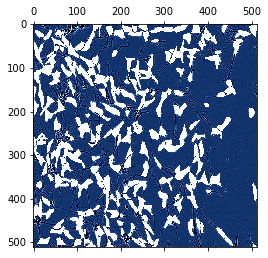

In [21]:
# Remember that data loader returns torch tensors because of default_collate(batch)
# Testing the DataLoader
test = iter(cell_dl)
img_id, img, mask = test.next()
img = img[0].numpy()
mask = mask[0].numpy()
masked = np.clip((mask + img), 0, 1)
plt.matshow(masked)

img_id, img, mask = test.next()
img = img[0].numpy()
mask = mask[0].numpy()
masked = np.clip((mask + img), 0, 1)
plt.matshow(masked)

img_id, img, mask = test.next()
img = img[0].numpy()
mask = mask[0].numpy()
masked = np.clip((mask + img), 0, 1)
plt.matshow(masked)

# Building a U-Net Model

Main Components:
* Contraction Path
    * Double Convolution
        * 3x3 unpadded
        * ReLU
    * Max Pooling
        * 2x2
        * Stride = 2
        * Downsampling
        * At each downsampling step, double the number of feature channels
* Expansion Path
    * Up - Convolution
        * 2x2
        * Upsampling of feature map
        * Halves the number of feature channels
    * Concatenation
        * With corresponding cropped feature map from contracting path
    * Double Convolution
        * 3x3
        * ReLU
    * Final Convolution
        * 1x1
        * Map each 64 component feature vector to the desired number of classes

* 23 Total Convolutional Layers
    

In [22]:
class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1), # Padding? Paper calls for none
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1), # Padding? Paper calls for none
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    
    def forward(self, x):
        return self.conv1(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.downsampling = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(2, 2, padding=1)
        # Contraction Layer
        self.downsampling.append(DoubleConv2d(in_channels, 64))
        self.downsampling.append(DoubleConv2d(64, 128))
        self.downsampling.append(DoubleConv2d(128, 256))
        self.downsampling.append(DoubleConv2d(256, 512))
        self.downsample_final = DoubleConv2d(512, 1024)
        
        # Expansion Layer
        self.upsampling1 = nn.ConvTranspose2d(1024, 512, 2, 2) # 512 * 2 because of skip connection
        self.upsampling2 = DoubleConv2d(1024, 512)
        self.upsampling3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.upsampling4 = DoubleConv2d(512, 256)
        self.upsampling5 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.upsampling6 = DoubleConv2d(256, 128)
        self.upsampling7 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.upsampling8 = DoubleConv2d(128, 64)
        
        # Final 1x1 Convolution
        self.conv_final = nn.Conv2d(64, out_channels, 1)
        
    def forward(self, x):
        skips = []
        # Contraction Layer
        #print(f'Initial Shape: {x.shape}')
        for layer in self.downsampling:
            x = layer(x)
            #print(x.shape)
            skips.append(x)
            x = self.maxpool(x)
        x = self.downsample_final(x)
        
        # Expansion Layer - kinda messy looking maybe another module list is needed
        x = self.upsampling1(x)
        if x.shape != skips[3].shape:
            x = TF.resize(x, size=skips[3].shape[2:])
        x = self.upsampling2(torch.cat((skips[3], x), dim=1))
        x = self.upsampling3(x)
        if x.shape != skips[2].shape:
            x = TF.resize(x, size=skips[2].shape[2:])
        x = self.upsampling4(torch.cat((skips[2], x), dim=1))
        x = self.upsampling5(x)
        if x.shape != skips[1].shape:
            x = TF.resize(x, size=skips[1].shape[2:])
        x = self.upsampling6(torch.cat((skips[1], x), dim=1))
        x = self.upsampling7(x)
        if x.shape != skips[0].shape:
            x = TF.resize(x, size=skips[0].shape[2:])
        x = self.upsampling8(torch.cat((skips[0], x), dim=1))
        return self.conv_final(x)
        

### Loss Function
* Intersect over Union

In [26]:
# Ref: https://www.kaggle.com/julian3833/sartorius-starter-baseline-torch-u-net
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [27]:
# Ref: https://www.kaggle.com/julian3833/sartorius-starter-baseline-torch-u-net
# Temp code I ripped from kaggle kernel in order to check model outputs
LEARNING_RATE = 5e-4
EPOCHS = 12
criterion = MixedLoss(10.0, 2.0)
model = UNet(512, 512).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(1, EPOCHS + 1):
    print(f"Starting epoch: {epoch} / {EPOCHS}")
    running_loss = 0.0
    optimizer.zero_grad()
    
    for batch_idx, batch in enumerate(cell_dl):
        #print(batch)
        # Predict
        img_id, images, masks = batch
        images, masks = images.cuda(),  masks.cuda()
        #plt.matshow(masks.to('cpu').numpy()[0] + images.to('cpu').numpy()[0])
        plt.show()
        outputs = model(images)
        #print(outputs.detach().to('cpu')[0].shape)
        #plt.matshow(outputs.detach().to('cpu')[0])
        loss = criterion(outputs, masks)
        print(f'Batch Loss: {loss}')
        # Back prop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    epoch_loss = running_loss / n_batches
    print(f"Epoch: {epoch} - Train Loss {epoch_loss:.4f}")

Starting epoch: 1 / 12
Batch Loss: 59.60272216796875
Batch Loss: 20.02491569519043
Batch Loss: 29.70867156982422
Batch Loss: 30.862594604492188
Batch Loss: 26.49413299560547
Batch Loss: 19.82600212097168
Batch Loss: 31.821224212646484
Batch Loss: 13.892192840576172
Batch Loss: 5.065951347351074
Batch Loss: 35.32659149169922
Batch Loss: 15.821256637573242
Batch Loss: 14.199352264404297
Batch Loss: 11.486555099487305
Batch Loss: 8.303581237792969
Batch Loss: 7.251659870147705
Batch Loss: 7.835425853729248
Batch Loss: 7.030821323394775
Batch Loss: 9.060588836669922
Batch Loss: 20.399429321289062
Batch Loss: 13.472015380859375
Batch Loss: 4.783154487609863
Batch Loss: 5.1657280921936035
Batch Loss: 5.070613384246826
Batch Loss: 5.71499490737915
Batch Loss: 9.448444366455078
Batch Loss: 4.487116813659668
Batch Loss: 6.424971103668213
Batch Loss: 10.019843101501465
Batch Loss: 7.744464874267578
Batch Loss: 6.710443496704102
Batch Loss: 4.66710090637207
Batch Loss: 6.774279594421387
Batch Los

IndexError: list index out of range